# **Analisis Deret Waktu**

**Menganalisis data curah hujan yang terrjadi di Lampung Tahun 2019-2021**

**import library yang dibutuhkan**

In [2]:
import numpy as np
import pandas as pd
from itertools import product
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**import data**

In [4]:
data = pd.read_csv('curah hujan lampung 2019-2021.csv')
df = pd.DataFrame(data)
df

,tahun,curah hujan
0,1/1/2019,300.5
1,1/2/2019,360.5
2,1/3/2019,133.6
3,1/4/2019,128.0
4,1/5/2019,331.1
5,1/6/2019,207.0
6,1/7/2019,120.9
7,1/8/2019,180.4
8,1/9/2019,123.6
9,1/10/2019,224.8


plotkan data untuk melihat apakah data stasioner atau tidak

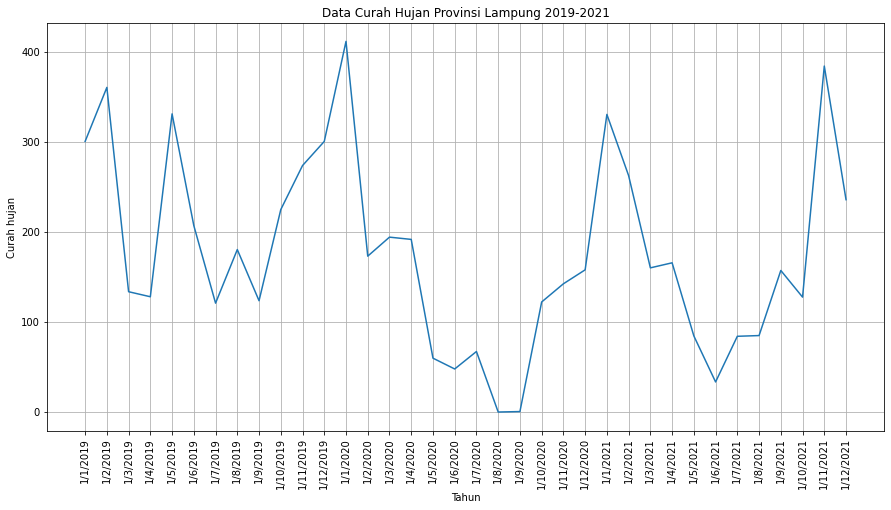

In [5]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['tahun'], data['curah hujan'])
plt.title('Data Curah Hujan Provinsi Lampung 2019-2021')
plt.ylabel('Curah hujan')
plt.xlabel('Tahun')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

**plot ACF dan PACF**
dari 

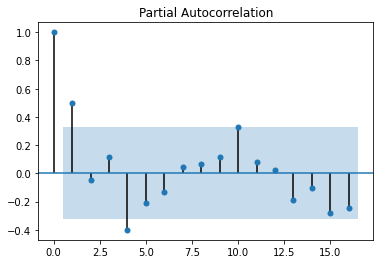

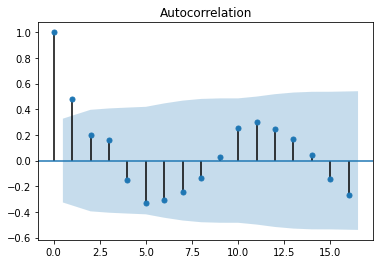

In [6]:
plot_pacf(data['curah hujan']);
plot_acf(data['curah hujan']);

p-value lebih kecil dari 0.05 artinya H0 ditolak, sehingga menghasilkan data yang **stasioner**

In [7]:
ad_fuller_result = adfuller(data['curah hujan'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.554368631460431
p-value: 0.0066957724752752055


In [18]:
# Seasonal differencing
data['curah hujan'] = data['curah hujan'].diff(4)
data = data.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)

In [19]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [20]:
p = range(0, 1, 1)
d = 1
q = range(0, 1, 1)
P = range(0, 1, 1)
D = 1
Q = range(0, 1, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

1


In [21]:
result_df = optimize_SARIMA(parameters_list, 0, 0, 1, data['curah hujan'])
result_df

  0%|          | 0/1 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 0, 0, 0)",350.163225


In [22]:
best_model = SARIMAX(data['curah hujan'], order=(0, 0, 1), seasonal_order=(0, 0, 1, 4)).fit(dis=-1)
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                       curah hujan   No. Observations:                   28
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 4)   Log Likelihood                -166.667
Date:                           Wed, 11 May 2022   AIC                            339.333
Time:                                   04:45:06   BIC                            343.330
Sample:                                        0   HQIC                           340.555
                                            - 28                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2056      0.259     -0.795      0.426      -0.712       0.301
ma.S.L4       -0.9974     42.904     -0.023

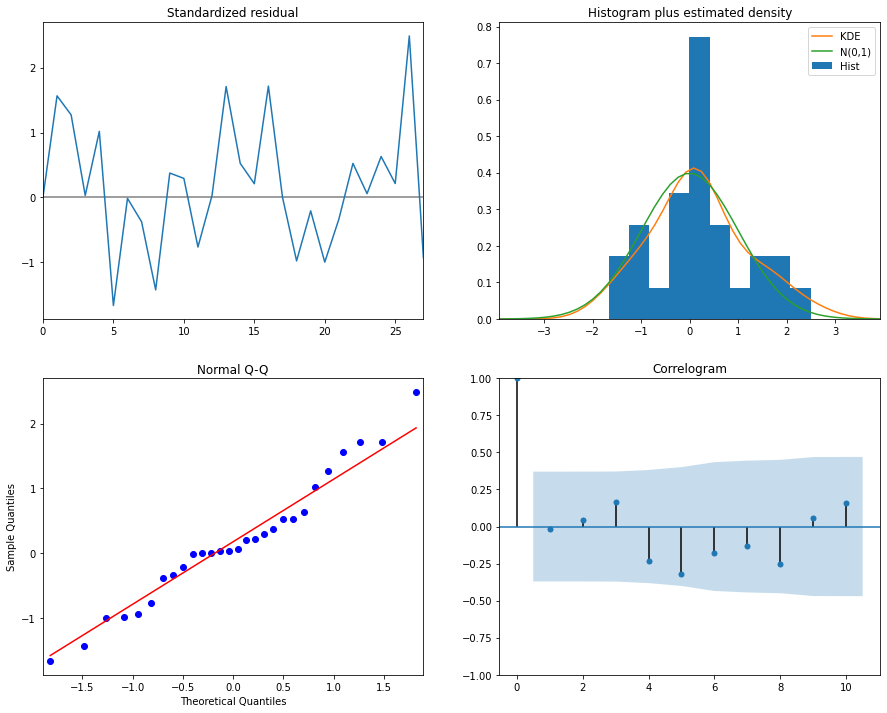

In [23]:
best_model.plot_diagnostics(figsize=(15,12));

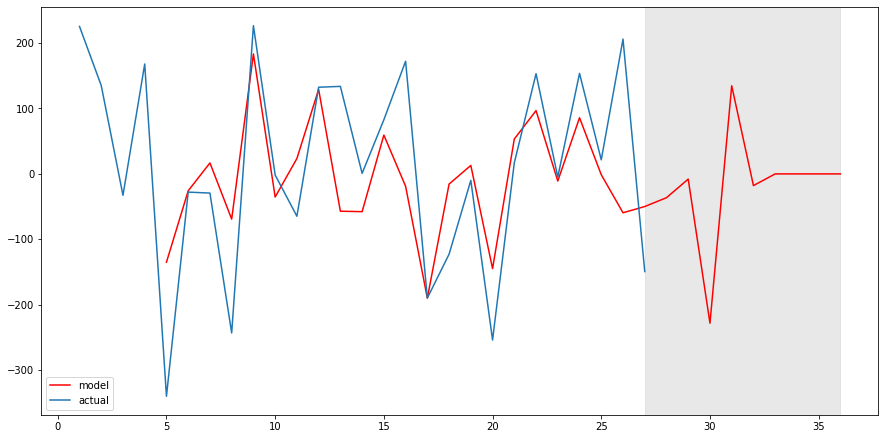

In [24]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 8)
forecast = data['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['curah hujan'], label='actual')
plt.legend()
plt.show()
